<a href="https://colab.research.google.com/github/SatyaKuppam/QUBOs-and-Ising-models/blob/master/covering_and_packing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Covering and packing problems:

* Exact cover

* Set Packing

* Vertex Cover

* Minimal Maximal Matching

In [ ]:
!pip install dwave-ocean-sdk

In [5]:
import networkx as nx
import dwave_networkx as dnx
import matplotlib
import matplotlib.pyplot as plt
import dimod
%matplotlib inline

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from dwave.cloud import Client
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from dwave_qbsolv import QBSolv
from collections import defaultdict

import networkx as nx
import dwave_networkx as dnx
import neal

# 1. Exact Cover

*Definition*: An instance $(U, V)$ of a set covering problem consists of a finite set $U$ and a family $H$ of subsets of $U$, such that every element of $U$ belongs to at least one subset in $V$. (From [1]).

* The subet $C_i \in V$ *covers* the elements of $U$. $$V = \{C_1...C_N\}$$ 
$$U = \bigcup\limits_{i=1}^{N} C_i$$  

* The problem is to find the minimum size subset $C \subseteq H$ whose members cover all elements of $U$. $$U = \bigcup\limits_{C_i \in C} C_i$$ This is $NP$-hard.

* The decision version of this problem is $NP$-complete. In the decision cersion we are asked if a covering exists with size atmost $k$.

## 1.1 Decision version

The energy functions for the decision version and the $NP$-hard version are derived from *Lucas*[2].

First the decision version: $H = H_A  + H_B$. $H_A$ ensures that we have an exact cover and $H_B$ ensure that the cover is atmost $k$ which the user provides.

$$H_A = \sum_{\alpha \in U} A(1 - \sum_{\alpha \in V_i} x_i)^2=\sum_{\alpha \in U} A(1 + \sum_{\alpha \in V_i}x_i \sum_{\alpha \in V_j}x_j - 2\sum_{\alpha \in V_i}x_i)$$

$$H_B = B (\sum_{i=1}^{|V|}x_i-k)$$

So we atleast need $|V|$ spins to encode this problem.

In [ ]:
class exact_cover:
  def __init__(self, U, V):
    self.U = U
    self.V = V
    self.vartype = dimod.BINARY
    self.linear = defaultdict(int)
    self.quadratic = defaultdict(int)
    self.offset = 0.0
    
    self.n = len(self.U)
    self.B = 1.0
    self.A = self.n * self.B + 1.0
    print(f"Setting A:{self.A} and B:{self.B}")
    self.N = len(self.V)

    if self.n == 0 or self.N == 0:
      raise ValueError("U or V cannot be empty.")

    self.solver = None

  def _energy_function_h_a(self):
    self.offset += self.A

    for u in self.U:
      for idx_i, v_i in enumerate(self.V):
        if u in v_i:
          for idx_j, v_j in enumerate(self.V):
            if u in v_j:
              if idx_i == idx_j:
                self.linear[idx_i] += self.A
              else:
                self.quadratic[(idx_i, idx_j)] += self.A
    
    for u in self.U:
      for idx, v_i in enumerate(self.V):
        if u in v_i:
          self.linear[idx] -= 2 * self.A

  def _energy_function_h_b(self, k=0.0):
    self.offset -= self.B * k

    for u in U:
      for idx, v_i in enumerate(V):
        self.linear[idx] += self.B

  def decide(self, k, solver=None, **kwargs):
    self._energy_function_h_a()
    self._energy_function_h_b(k)
    return self._solve(solver=solver, **kwargs)

  def solve(self, solver=None, **kwargs):
    self._energy_function_h_a()
    self._energy_function_h_b()
    return self._solve(solver=solver, **kwargs)

  def _solve(self, solver=None, **kwargs):
    if solver == None:
      print("Setting the solver as QBsolv")
      solver = QBSolv()

    print(self.linear)
    print(self.quadratic)
    print(self.offset)
    bqm = dimod.BinaryQuadraticModel(self.linear, self.quadratic, self.offset,
                                     self.vartype)
    return solver.sample(bqm, **kwargs)
  

## 1.2 Testing $H_A$
All covers should be equally likely.

In [ ]:
U = [1,2,3,4,5,6]
V = [[1], [2], [3],[4],[5],[6],[1,2],[3,4],[5,6]]

exact_cover_decision_h_a = exact_cover(U, V)
exact_cover_decision_h_a._energy_function_h_a()
exact_cover_decision_h_a._solve(num_repeats=1000)

Setting A:7.0 and B:1.0
Setting the solver as QBsolv
defaultdict(<class 'int'>, {0: -7.0, 6: -14.0, 1: -7.0, 2: -7.0, 7: -14.0, 3: -7.0, 4: -7.0, 8: -14.0, 5: -7.0})
defaultdict(<class 'int'>, {(0, 6): 7.0, (6, 0): 7.0, (1, 6): 7.0, (6, 1): 7.0, (2, 7): 7.0, (7, 2): 7.0, (3, 7): 7.0, (7, 3): 7.0, (4, 8): 7.0, (8, 4): 7.0, (5, 8): 7.0, (8, 5): 7.0})
7.0


SampleSet(rec.array([([0, 0, 1, 1, 1, 1, 1, 0, 0], -35., 132),
           ([0, 0, 0, 0, 0, 0, 1, 1, 1], -35., 119),
           ([0, 0, 1, 1, 0, 0, 1, 0, 1], -35., 124),
           ([0, 0, 0, 0, 1, 1, 1, 1, 0], -35., 125),
           ([1, 1, 0, 0, 0, 0, 0, 1, 1], -35., 129),
           ([1, 1, 1, 1, 0, 0, 0, 0, 1], -35., 128),
           ([1, 1, 0, 0, 1, 1, 0, 1, 0], -35., 110),
           ([1, 1, 1, 1, 1, 1, 0, 0, 0], -35., 134)],
          dtype=[('sample', 'i1', (9,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), [0, 1, 2, 3, 4, 5, 6, 7, 8], {}, 'BINARY')

## 1.3 Testing $H_B$
No subset should be selected because the minimum energy possible is $-Bk$.

In [ ]:
exact_cover_decision_h_b = exact_cover(U, V)
exact_cover_decision_h_b._energy_function_h_b(k=3)
exact_cover_decision_h_b._solve(num_repeats=1000)

Setting A:7.0 and B:1.0
Setting the solver as QBsolv
defaultdict(<class 'int'>, {0: 6.0, 1: 6.0, 2: 6.0, 3: 6.0, 4: 6.0, 5: 6.0, 6: 6.0, 7: 6.0, 8: 6.0})
defaultdict(<class 'int'>, {})
-3.0


SampleSet(rec.array([([0, 0, 0, 0, 0, 0, 0, 0, 0], -3., 1001)],
          dtype=[('sample', 'i1', (9,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), [0, 1, 2, 3, 4, 5, 6, 7, 8], {}, 'BINARY')

## 1.4 Experimentation:
 $C=[[1,2],[3,4],[5,6]]$ should be selected with high probability.

In [ ]:
exact_cover_decision = exact_cover(U, V)
exact_cover_decision.decide(k=3, num_repeats=1000)

Setting A:7.0 and B:1.0
Setting the solver as QBsolv
defaultdict(<class 'int'>, {0: -1.0, 6: -8.0, 1: -1.0, 2: -1.0, 7: -8.0, 3: -1.0, 4: -1.0, 8: -8.0, 5: -1.0})
defaultdict(<class 'int'>, {(0, 6): 7.0, (6, 0): 7.0, (1, 6): 7.0, (6, 1): 7.0, (2, 7): 7.0, (7, 2): 7.0, (3, 7): 7.0, (7, 3): 7.0, (4, 8): 7.0, (8, 4): 7.0, (5, 8): 7.0, (8, 5): 7.0})
4.0


SampleSet(rec.array([([0, 0, 0, 0, 0, 0, 1, 1, 1], -20., 605),
           ([0, 0, 1, 1, 0, 0, 1, 0, 1], -14., 160),
           ([0, 0, 0, 0, 1, 1, 1, 1, 0], -14., 103),
           ([1, 1, 0, 0, 0, 0, 0, 1, 1], -14., 136)],
          dtype=[('sample', 'i1', (9,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), [0, 1, 2, 3, 4, 5, 6, 7, 8], {}, 'BINARY')

No solution exists with $k=2$.

In [ ]:
exact_cover_decision = exact_cover(U, V)
exact_cover_decision.decide(k=2, num_repeats=1000)

Setting A:7.0 and B:1.0
Setting the solver as QBsolv
defaultdict(<class 'int'>, {0: -1.0, 6: -8.0, 1: -1.0, 2: -1.0, 7: -8.0, 3: -1.0, 4: -1.0, 8: -8.0, 5: -1.0})
defaultdict(<class 'int'>, {(0, 6): 7.0, (6, 0): 7.0, (1, 6): 7.0, (6, 1): 7.0, (2, 7): 7.0, (7, 2): 7.0, (3, 7): 7.0, (7, 3): 7.0, (4, 8): 7.0, (8, 4): 7.0, (5, 8): 7.0, (8, 5): 7.0})
5.0


SampleSet(rec.array([([0, 0, 0, 0, 0, 0, 1, 1, 1], -19., 604),
           ([1, 1, 0, 0, 0, 0, 0, 1, 1], -13., 157),
           ([0, 0, 0, 0, 1, 1, 1, 1, 0], -13., 109),
           ([0, 0, 1, 1, 0, 0, 1, 0, 1], -13., 134)],
          dtype=[('sample', 'i1', (9,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), [0, 1, 2, 3, 4, 5, 6, 7, 8], {}, 'BINARY')

For $k=4$, we observe that its not the ground state, although solution is possible.

In [ ]:
exact_cover_decision = exact_cover(U, V)
exact_cover_decision.decide(k=4, num_repeats=1000)

Setting A:7.0 and B:1.0
Setting the solver as QBsolv
defaultdict(<class 'int'>, {0: -1.0, 6: -8.0, 1: -1.0, 2: -1.0, 7: -8.0, 3: -1.0, 4: -1.0, 8: -8.0, 5: -1.0})
defaultdict(<class 'int'>, {(0, 6): 7.0, (6, 0): 7.0, (1, 6): 7.0, (6, 1): 7.0, (2, 7): 7.0, (7, 2): 7.0, (3, 7): 7.0, (7, 3): 7.0, (4, 8): 7.0, (8, 4): 7.0, (5, 8): 7.0, (8, 5): 7.0})
3.0


SampleSet(rec.array([([0, 0, 0, 0, 0, 0, 1, 1, 1], -21., 591),
           ([0, 0, 0, 0, 1, 1, 1, 1, 0], -15., 100),
           ([0, 0, 1, 1, 0, 0, 1, 0, 1], -15., 171),
           ([1, 1, 0, 0, 0, 0, 0, 1, 1], -15., 142)],
          dtype=[('sample', 'i1', (9,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), [0, 1, 2, 3, 4, 5, 6, 7, 8], {}, 'BINARY')

We will find the smallest exact cover. The solution should choose $C=[[1,2],[3,4],[5,6]]$ with high probability.

In [ ]:
exact_cover_find = exact_cover(U, V)
exact_cover_find.solve(num_repeats=1000)

Setting A:7.0 and B:1.0
Setting the solver as QBsolv
defaultdict(<class 'int'>, {0: -1.0, 6: -8.0, 1: -1.0, 2: -1.0, 7: -8.0, 3: -1.0, 4: -1.0, 8: -8.0, 5: -1.0})
defaultdict(<class 'int'>, {(0, 6): 7.0, (6, 0): 7.0, (1, 6): 7.0, (6, 1): 7.0, (2, 7): 7.0, (7, 2): 7.0, (3, 7): 7.0, (7, 3): 7.0, (4, 8): 7.0, (8, 4): 7.0, (5, 8): 7.0, (8, 5): 7.0})
7.0


SampleSet(rec.array([([0, 0, 0, 0, 0, 0, 1, 1, 1], -17., 582),
           ([1, 1, 0, 0, 0, 0, 0, 1, 1], -11., 128),
           ([0, 0, 0, 0, 1, 1, 1, 1, 0], -11.,  96),
           ([0, 0, 1, 1, 0, 0, 1, 0, 1], -11., 198)],
          dtype=[('sample', 'i1', (9,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), [0, 1, 2, 3, 4, 5, 6, 7, 8], {}, 'BINARY')

# 2. Set Packing

## 2.1 Problem Definition:

We have a set of elements $U = \{1..n\}$ and a set $H=\{V_1, V_2,..V_N\}$ such that $V_i = \{x|x\in U\}$. We need to find $C \subseteq H$ which is the largest set of subsets $V_i$ such that they are all disjoint. 

NOTE: $C$ does not have to form a cover.



### Equivalence to a graph problem
This is equivalent to the maximal inpendent set (MIS) problem, if we have a graph $G=(V,E)$ such that, for every $V_i$ in $H$ we have a vertex in $G$ and an edge exists between the vertices in the graph iff $V_i\cap V_j \neq \emptyset$. Then what is the maximal number of vertices that can be coloured such that no two coloured vertices are connected by an edge.


### 2.1.1 Energy Function:

* $H = H_A + H_B$
* $H_A$ penalizes $V_i$'s that are not disjoint.
* $H_B$ ensures that $|C|$ is maximum.
* $H_A = A\sum\limits_{i,j: V_i \cap V_j \neq \emptyset} x_ix_j$
* $H_B = -B\sum\limits_{i}x_i$
* A > B

where $x_i \in \{0,1\}$

## 2.2 Experimentation



In [16]:
from itertools import combinations

class SetPacking:
  def __init__(self, U, V):
    self.U = U
    self.V = V
    self.vartype = dimod.BINARY
    self.linear = defaultdict(int)
    self.quadratic = defaultdict(int)
    self.offset = 0.0
    
    self.n = len(self.U)
    self.B = 1.0
    self.A = 10 * self.B
    print(f"Setting A:{self.A} and B:{self.B}")
    self.N = len(self.V)

    if self.n == 0 or self.N == 0:
      raise ValueError("U or V cannot be empty.")

    self.solver = None

  def _energy_function_h_a(self):
    for idx_i, idx_j in list(combinations(range(len(self.V)), 2)):
      if len(list(set(self.V[idx_i]) & set(self.V[idx_j]))) > 0:
        self.quadratic[(idx_i, idx_j)] += self.A

  def _energy_function_h_b(self):
    for idx in range(len(self.V)):
      self.linear[idx] -= self.B

  def solve(self, solver=None, **kwargs):
    self._energy_function_h_a()
    self._energy_function_h_b()
    return self._solve(solver=solver, **kwargs)

  def _solve(self, solver=None, **kwargs):
    if solver == None:
      print("Setting the solver as QBsolv")
      solver = QBSolv()

    print(self.linear)
    print(self.quadratic)
    print(self.offset)
    bqm = dimod.BinaryQuadraticModel(self.linear, self.quadratic, self.offset,
                                     self.vartype)
    return solver.sample(bqm, **kwargs)
  

In [18]:
U = [1,2,3,4,5,6]
V = [[1,2],[3,4],[5,6], [1,2,3],[3,4,5], [4,5,6]]

# test h_a energy function
set_packing_h_a = SetPacking(U, V)
set_packing_h_a._energy_function_h_a()
set_packing_h_a._energy_function_h_b()
set_packing_h_a._solve(num_repeats=1000)

Setting A:10.0 and B:1.0
Setting the solver as QBsolv
defaultdict(<class 'int'>, {0: -1.0, 1: -1.0, 2: -1.0, 3: -1.0, 4: -1.0, 5: -1.0})
defaultdict(<class 'int'>, {(0, 3): 10.0, (1, 3): 10.0, (1, 4): 10.0, (1, 5): 10.0, (2, 4): 10.0, (2, 5): 10.0, (3, 4): 10.0, (4, 5): 10.0})
0.0


SampleSet(rec.array([([1, 1, 1, 0, 0, 0], -3., 965), ([1, 0, 0, 0, 1, 0], -2.,  37)],
          dtype=[('sample', 'i1', (6,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), [0, 1, 2, 3, 4, 5], {}, 'BINARY')

# 3. Vertex Cover

## 3.1 Problem Definition

Given a directed graph $G = (V, E)$ what is the smallest number of vertices that can be coloured such that every edge is incident to a coloured vertex.


### 3.1.1 Energy Function.

Let $x_v$ be a binary variable for each vertex, that is $0$ when the vertex is not cloured, but $1$ when its is.

* $H = H_A + H_B$
* $H_A = A \sum\limits_{x,v\in E}(1-x_u)(1-x_v) = A(|E| + \sum\limits_{x,v \in E}x_ux_v-x_u-x_v)$
* $H_B = B \sum\limits_{v} x_v$

## 3.2 Experimentations

In [58]:
from itertools import combinations

class VertexCover:
  def __init__(self, G):
    self.vartype = dimod.BINARY
    self.linear = defaultdict(int)
    self.quadratic = defaultdict(int)
    self.offset = 0.0

    self.B = 1.0
    self.A = 10.0 * self.B
    print(f"Setting A:{self.A} and B:{self.B}")
    self.G = G
    self.solver = None

  def _energy_function_h_a(self):
    for u, v in self.G.edges():
      self.offset += self.A
      self.linear[u] -= self.A
      self.linear[v] -= self.A
      self.quadratic[(u, v)] += self.A

  def _energy_function_h_b(self):
    for idx in range(len(self.G.nodes())):
      self.linear[idx] += self.B

  def solve(self, solver=None, **kwargs):
    self._energy_function_h_a()
    self._energy_function_h_b()
    return self._solve(solver=solver, **kwargs)

  def _solve(self, solver=None, **kwargs):
    if solver == None:
      print("Setting the solver as QBsolv")
      solver = QBSolv()

    print(self.linear)
    print(self.quadratic)
    print(self.offset)
    bqm = dimod.BinaryQuadraticModel(self.linear, self.quadratic, self.offset,
                                     self.vartype)
    return solver.sample(bqm, **kwargs)
  

{0: Text(0.0005584830638797252, 0.001620121988841208, '0'),
 1: Text(0.04787180948336928, -1.0, '1'),
 2: Text(-0.6539035968808192, -0.7580909027598135, '2'),
 3: Text(0.6512507923069597, 0.7580990584101648, '3'),
 4: Text(-0.04577748797338965, 0.9983717223608077, '4')}

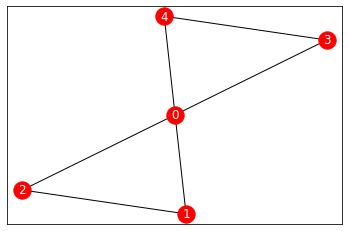

In [62]:
## Define the graph
G_three = nx.Graph()
G_three.add_edges_from([(0,1),(0,2),(0,3),(0,4),(1,2),(3,4)])
pos = nx.spring_layout(G_three)

nx.draw_networkx_nodes(G_three, nodelist=G_three.nodes(), pos=pos, node_color='r')
nx.draw_networkx_edges(G_three, pos)
nx.draw_networkx_labels(G_three, pos, font_color='w', font_size=12)

In [63]:
vertex_cover = VertexCover(G_three)
vertex_cover._energy_function_h_a()
vertex_cover._energy_function_h_b()
vertex_cover._solve(num_repeats=1000)

Setting A:10.0 and B:1.0
Setting the solver as QBsolv
defaultdict(<class 'int'>, {0: -39.0, 1: -19.0, 2: -19.0, 3: -19.0, 4: -19.0})
defaultdict(<class 'int'>, {(0, 1): 10.0, (0, 2): 10.0, (0, 3): 10.0, (0, 4): 10.0, (1, 2): 10.0, (3, 4): 10.0})
60.0


SampleSet(rec.array([([1, 1, 0, 0, 1], 3., 236), ([1, 0, 1, 1, 0], 3., 242),
           ([1, 0, 1, 0, 1], 3., 250), ([1, 1, 0, 1, 0], 3., 273)],
          dtype=[('sample', 'i1', (5,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), [0, 1, 2, 3, 4], {}, 'BINARY')

# References:

[1] Cormen, Thomas H., Charles E. Leiserson, Ronald L. Rivest, and Clifford Stein. *Introduction to algorithms.* MIT press, 2009.

[2] Lucas, Andrew. "Ising formulations of many NP problems." *Frontiers in Physics 2* (2014): 5.
